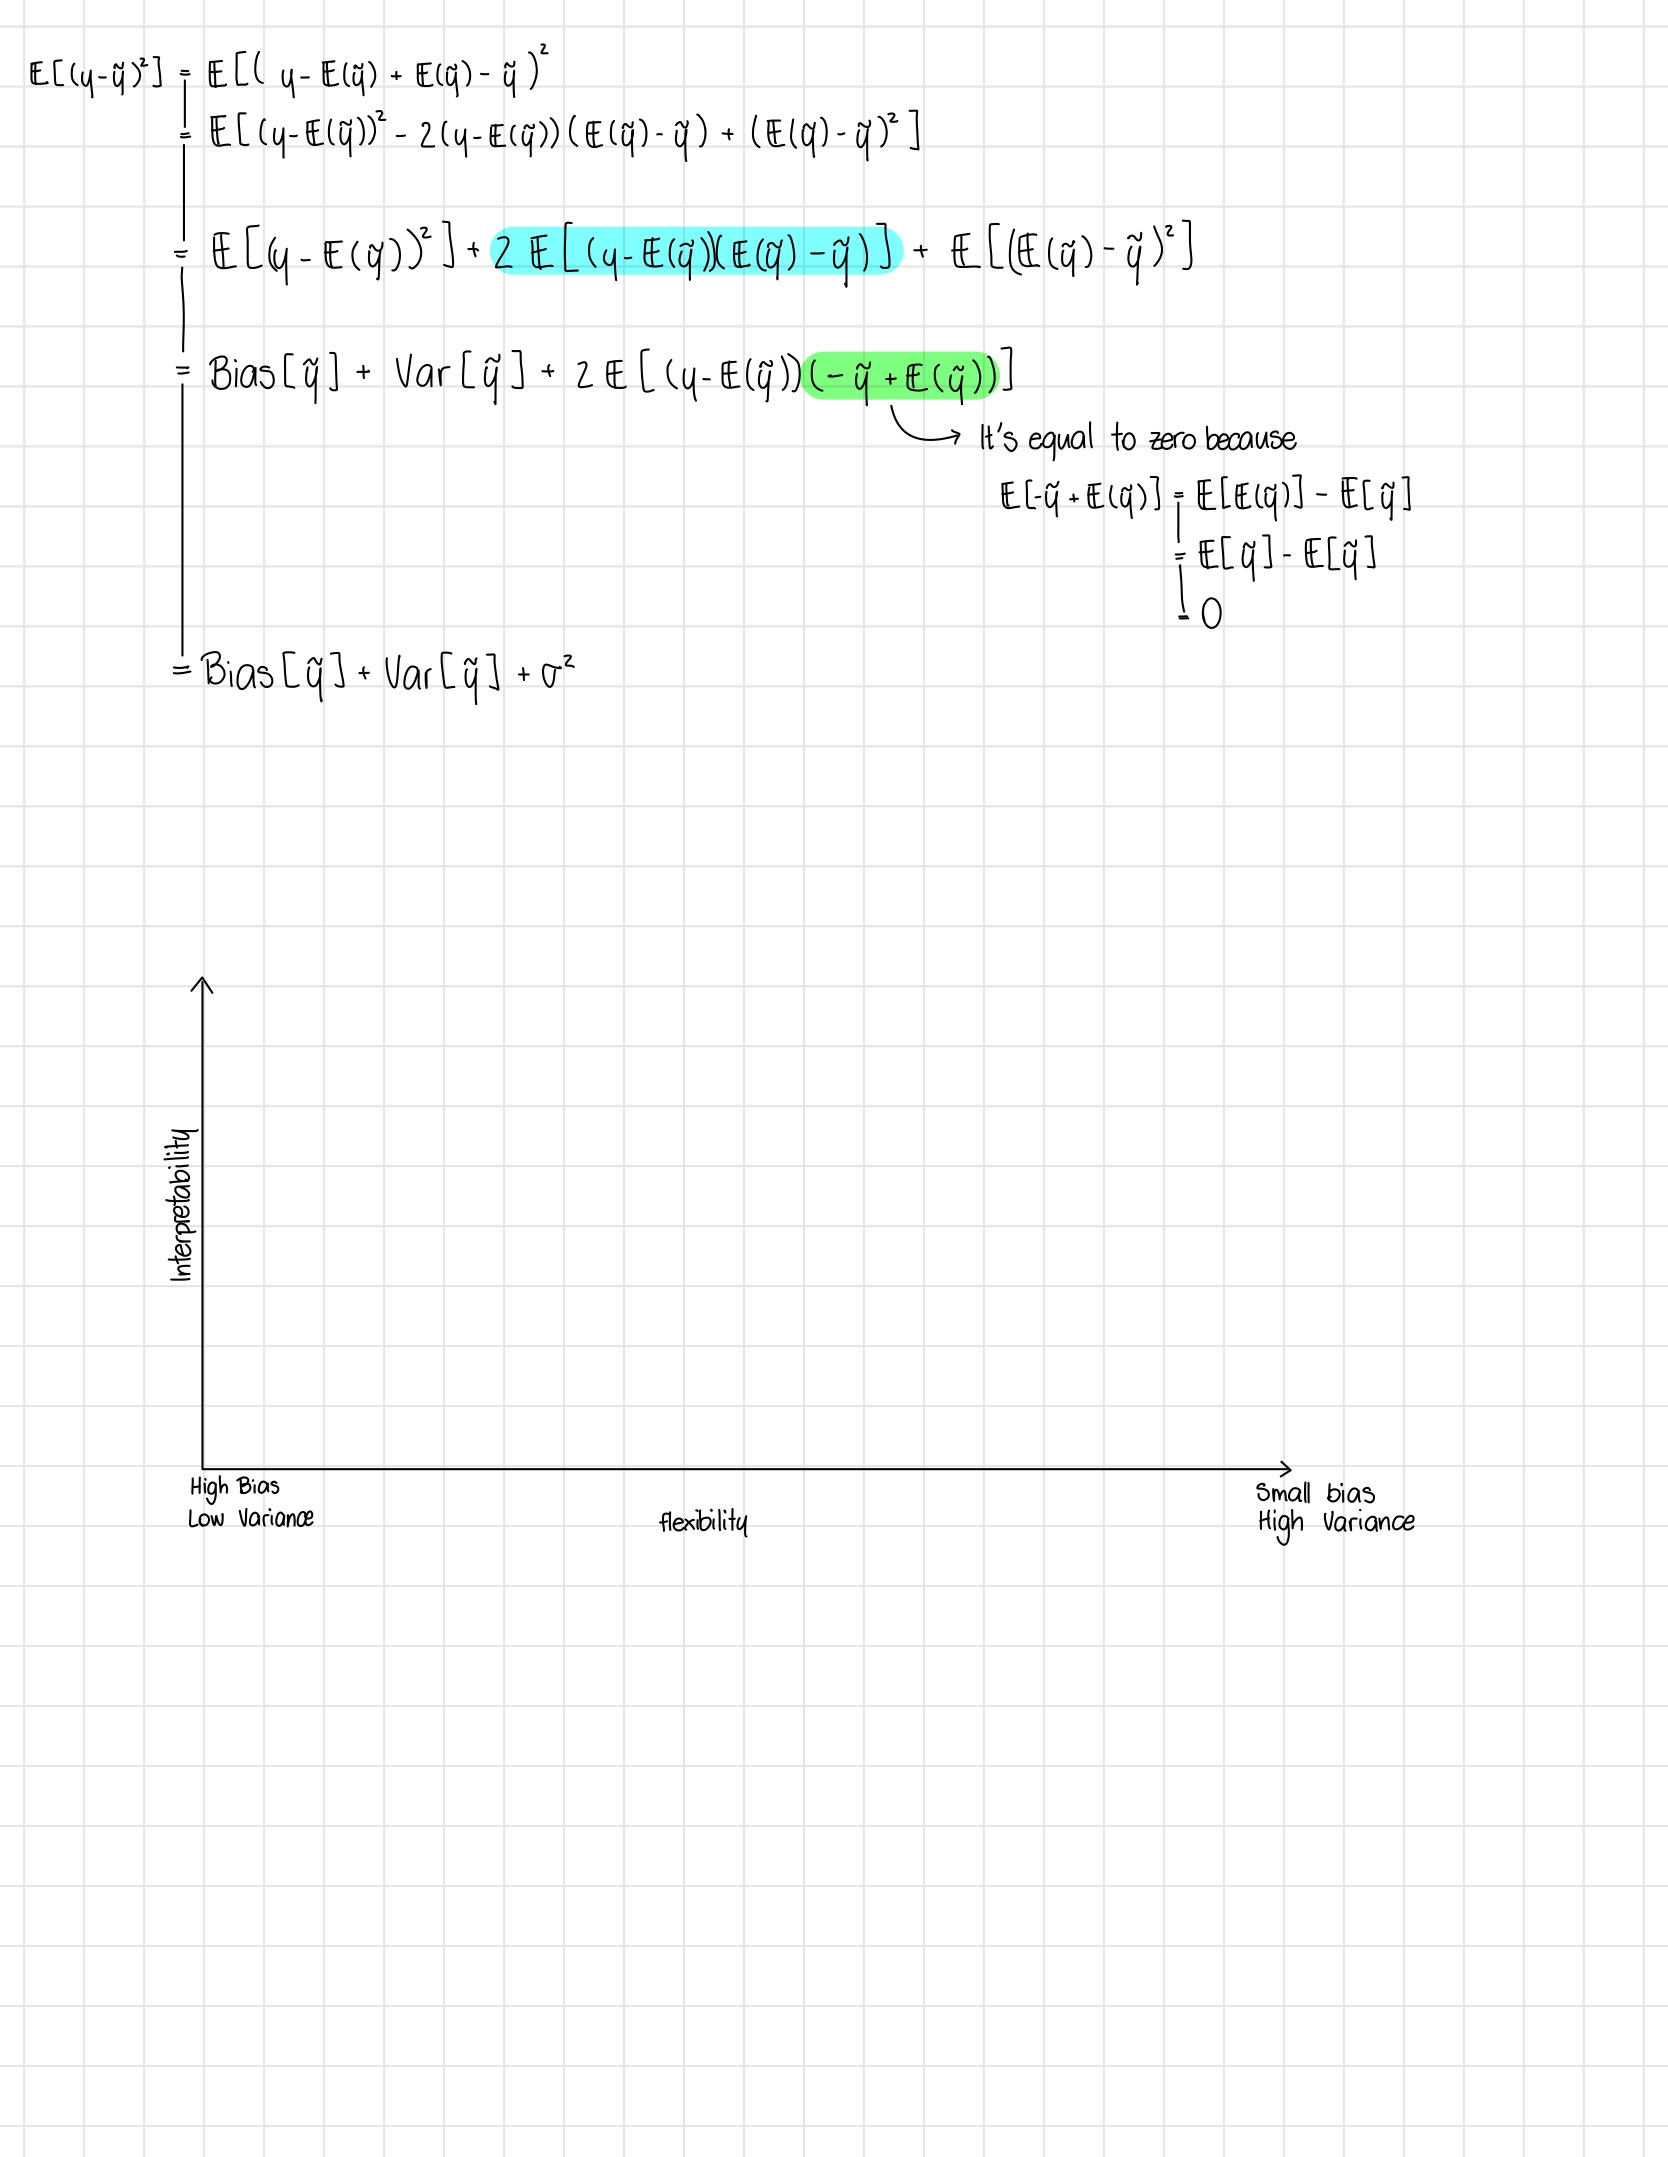

The variance refers to the amount by which our model would change if we estimated it using a different training data set. Since the training data are used to fit the statistical learning method, different training data sets will result in a different estimate. But ideally the estimate for our model should not vary too much between training sets. However, if a method has high variance then small changes in the training data can result in large changes in the model. In general, more flexible statistical methods have higher variance.

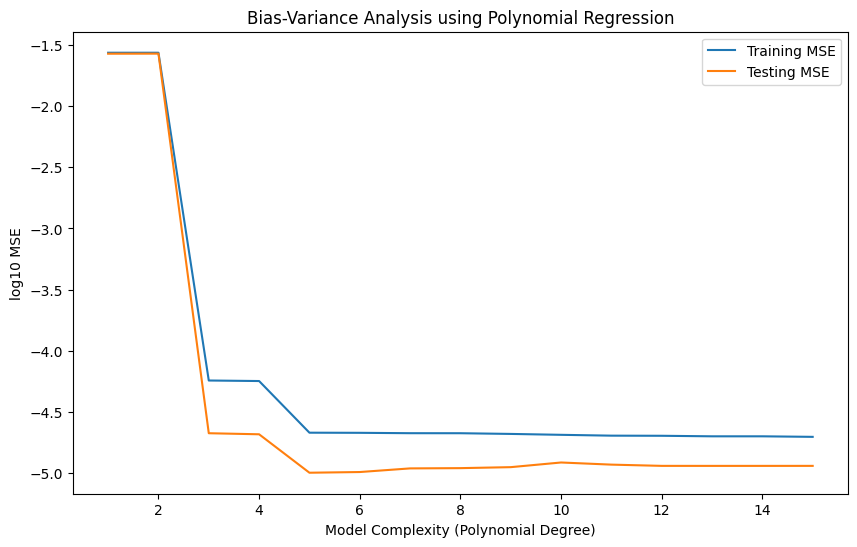

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(457)

# Generate data
n_samples = 500
X = np.linspace(0, 1, n_samples).reshape(-1, 1)
y = np.sin(2 * np.pi * X).ravel() + np.random.normal(scale=0.1, size=n_samples)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_mse = []
test_mse = []

# Maximum polynomial degree
max_degree = 15

# Loop for different degrees
for degree in range(1, max_degree + 1):
    # Poly feature
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Fitting
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # MSE
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_degree + 1), np.log(train_mse), label='Training MSE')
plt.plot(range(1, max_degree + 1), np.log(test_mse), label='Testing MSE')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('log10 MSE')
plt.title('Bias-Variance Analysis using Polynomial Regression')
plt.legend()
plt.show()

- **Training MSE**: Decreases as the polynomial degree (model complexity)
increases. This is expected because more complex models can fit the training data more closely, potentially leading to lower bias.
- **Testing MSE**: Initially decreases, indicating that a slightly more complex model generalizes better. However, after a certain point, the testing MSE starts to increase, indicating overfitting.

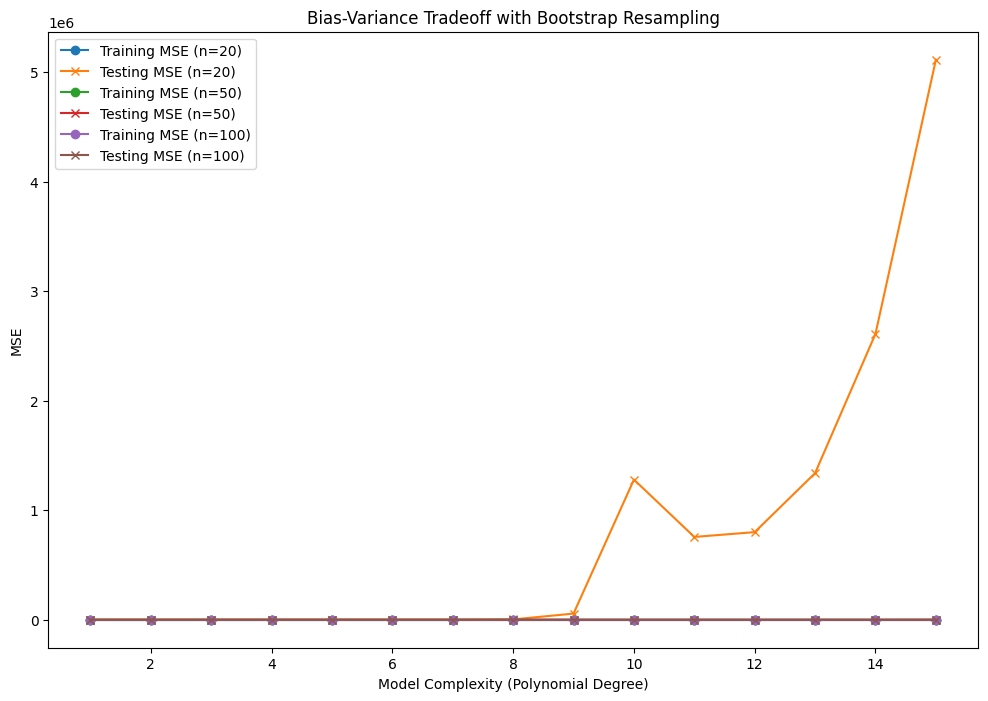

In [65]:
from sklearn.utils import resample

np.random.seed(457)

n_bootstrap = 100
max_degree = 15

data_points_list = [20, 50, 100]
bootstrap_results = {}

# Perform bootstrap resampling and bias-variance analysis
for n_samples in data_points_list:
    # Generate data
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)
    y = np.sin(2 * np.pi * X).ravel() + np.random.normal(scale=0.1, size=n_samples)  # true function + noise

    # Store MSE values for each degree
    train_mse_avg = np.zeros(max_degree)
    test_mse_avg = np.zeros(max_degree)

    # Bootstrap resampling
    for _ in range(n_bootstrap):
        # Resample the data
        X_resampled, y_resampled = resample(X, y, n_samples=int(0.8 * n_samples))
        X_oob = np.array([x for x in X if x.tolist() not in X_resampled.tolist()])
        y_oob = np.array([y for x, y in zip(X, y) if x.tolist() not in X_resampled.tolist()])

        # Skip iteration if no OOB samples
        if len(X_oob) == 0:
            continue

        # Calculate MSE for different polynomial degrees
        for degree in range(1, max_degree + 1):
            # Create polynomial features
            poly = PolynomialFeatures(degree)
            X_train_poly = poly.fit_transform(X_resampled)
            X_test_poly = poly.transform(X_oob)

            # Fit linear regression model
            model = LinearRegression()
            model.fit(X_train_poly, y_resampled)

            # Predict and calculate MSE
            y_train_pred = model.predict(X_train_poly)
            y_test_pred = model.predict(X_test_poly)
            train_mse_avg[degree - 1] += mean_squared_error(y_resampled, y_train_pred)
            test_mse_avg[degree - 1] += mean_squared_error(y_oob, y_test_pred)

    # Average the MSE over all bootstrap samples
    train_mse_avg /= n_bootstrap
    test_mse_avg /= n_bootstrap

    # Store results
    bootstrap_results[n_samples] = {
        'train_mse': train_mse_avg,
        'test_mse': test_mse_avg
    }

# Plot
plt.figure(figsize=(12, 8))
for n_samples in data_points_list:
    plt.plot(range(1, max_degree + 1), bootstrap_results[n_samples]['train_mse'], label=f'Training MSE (n={n_samples})', marker='o')
    plt.plot(range(1, max_degree + 1), bootstrap_results[n_samples]['test_mse'], label=f'Testing MSE (n={n_samples})', marker='x')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff with Bootstrap Resampling')
plt.legend()
plt.show()
